# Total Pressure Inlet Condition 

In [22]:
using Ferrite
using SparseArrays
using LinearAlgebra # provides mul! 
using UnPack # added for time integration using DifferentialEquations.jl 
using OrdinaryDiffEq # added for time integration using DifferentialEquations.jl
using DifferentialEquations # added for time integration using DifferentialEquations.jl
using WriteVTK
using Plots 

## Section 1: Introduction 

The <b>total pressure inlet condition</b> imposes that on the inlet patch $p_{total} = p_{static} + p_{dynamic}$. We recall that only total quantities are conserved. The condition implies that 
$p_{total} = p_{static} + 0.5 \, \rho \, \vec{v} \cdot \vec{v}$, where $p_{static}$ is the pressure solved for in the Navier-Stokes model. Physically speaking, we have that 

<b>Initial Pressure Difference</b>: If the inlet pressure (total pressure) is higher than the initial pressure inside the vessel, fluid flows into the vessel, increasing the internal pressure. This flow is driven by the pressure gradient between the inlet and the pressure inside the reservoir.
What happens next:

<b>Pressure Equilibration</b>: As fluid enters the closed vessel, the inner static pressure rises. For incompressible flow (or compressible flow within a rigid reservoir), the pressure increase is directly related to the added mass. For compressible fluids, density changes also contribute to pressure buildup and must be taken into account.

<b>Dynamic to Static Pressure Transition</b>: The inlet's total pressure includes static and dynamic components. As the vessel's internal static pressure approaches the inlet's total pressure, the dynamic pressure (velocity-dependent term) diminishes, slowing the flow.

<b>Steady-State Condition</b>: When the vessel's static pressure equals the inlet's total pressure, the pressure gradient driving the flow vanishes. At this point, the inflow velocity reduces to zero, and the system reaches a steady state with no net flow. See also, [this video](https://www.youtube.com/watch?v=Er2j5Kq17as)

The total pressure inlet condition is standard in various packages. These include 
[Fluent Users Guide](https://www.afs.enea.it/project/neptunius/docs/fluent/html/ug/node239.htm) and [OpenFoam Example](https://doc.openfoam.com/2306/tools/processing/boundary-conditions/rtm/derived/inletOutlet/totalPressure/). In this notebook we explore the implementation of this non-linear boundary condition is an existing FEM solver.   

## Section 2: Model Problem 

### Section 1.2: Linear Model Problem 

### Section 2.2: Non-Linear Model Problem 

## Section 3: Solution Approaches    

### Section 1.3: Penalty Method 

For the non-linear constraints using the [penalty method](https://en.wikipedia.org/wiki/Penalty_method), it suffices to add a boundary term to the weak form. More specifically, one adds to the weak form the term p $\int_{\Gamma_{inlet}} [u^2 - 1] \, v \, d\Gamma$, where p is a weighting factor and v is the test function. The weighting factor p is initially zero and increases (to give more weight to the constraint to be imposed) as convergence is obtained. In a transient solution process, the weighting parameter p can be scaled with time. 

For the implementation of integrals over the boundary, the incompressible elasticity tutorial provides a good example. Look for the comment “We integrate the Neumann boundary using the FacetValues.” This part of the weak form needs to be updated with time. This is similar to the update of the non-linear part of the Jacobian in the incompressible Navier-Stokes tutorial. 

### Section 2.2: Lagrangian Multiplier Method 

For the (again, back to) linear constraints using this time Lagrange multipliers (as opposed to AffineConstraints that Ferrite already provides), I would need to look into the details. (For now, see [Lagrangian multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier). 

## Section 4: Linear Scalar Diffusion   

In [29]:
function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)

    assembler = start_assemble(K, f)

    for cell in CellIterator(dh)

        fill!(Ke, 0)
        fill!(fe, 0)

        Ferrite.reinit!(cellvalues, cell)

        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point)

            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)
                ∇v = shape_gradient(cellvalues, q_point, i)
                fe[i] += v * dΩ
                for j in 1:n_basefuncs
                    ∇u = shape_gradient(cellvalues, q_point, j)
                    Ke[i, j] += (∇v ⋅ ∇u) * dΩ
                end
            end
        end

        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

function assemble_M!(M::SparseMatrixCSC, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
    Me = zeros(n_basefuncs, n_basefuncs)

    assembler = start_assemble(M)

    for cell in CellIterator(dh)

        fill!(Me, 0)

        reinit!(cellvalues, cell)

        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point)

            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)
                for j in 1:n_basefuncs
                    u = shape_value(cellvalues, q_point, j)
                    Me[i, j] += (v * u) * dΩ
                end
            end
        end

        assemble!(assembler, celldofs(cell), Me)
    end
    return M
end

function setup_mean_constraint(dh, fvu)
    assembler = Ferrite.COOAssembler()
    # All external boundaries
    set = union(getfacetset(dh.grid, "left"))
    # Allocate buffers
    range_u = dof_range(dh, :u)
    element_dofs = zeros(Int, ndofs_per_cell(dh))
    element_dofs_u = view(element_dofs, range_u)
    element_coords = zeros(Vec{2}, 4) # assuming 2D mesh with quadrilaterals only
    Ce = zeros(1, length(range_u)) # Local constraint matrix (only 1 row)
    # Loop over all the boundaries
    for (ci, fi) in set
        Ce .= 0
        getcoordinates!(element_coords, dh.grid, ci)
        Ferrite.reinit!(fvu, element_coords, fi)
        celldofs!(element_dofs, dh, ci)
        for qp in 1:getnquadpoints(fvu)
            dΓ = getdetJdV(cvu, qp)
            for i in 1:getnbasefunctions(fvu)
                Ce[1, i] += shape_value(fvu, qp, i) * dΓ
            end
        end
        # Assemble to row 1
        assemble!(assembler, [1], element_dofs_u, Ce)
    end
    C, _ = finish_assemble(assembler)
    # Create an AffineConstraint from the C-matrix
    _, J, V = findnz(C)
    _, constrained_dof_idx = findmax(abs2, V)
    constrained_dof = J[constrained_dof_idx]
    V ./= V[constrained_dof_idx]
    mean_value_constraint = AffineConstraint(
        constrained_dof,
        Pair{Int, Float64}[J[i] => -V[i] for i in 1:length(J) if J[i] != constrained_dof],
        0.0,
    )
    return mean_value_constraint
end

setup_mean_constraint (generic function with 1 method)

In [116]:
function mypostprocess(u, dh, cvu, nels)

    numcells = nels[1]*nels[2]
    area = zeros(numcells)
    myu  = zeros(numcells)

    for (cell_num, cell) in enumerate(CellIterator(dh))

        Ferrite.reinit!(cvu, cell)
        
        dof_range_u = dof_range(dh,:u)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        Ferrite.reinit!(cvu, cell)

        cellarea = 0. 
        cellu = 0 
    
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point)
            celluq = function_value(cvu, q_point, uloc)
            cellarea += dΩ 
            cellu += celluq*dΩ
        end

        area[cell_num] = cellarea
        myu[cell_num]  = cellu
    
    end  

    myu2d = reshape(myu, nels[1], nels[2])
    
    return area, myu2d 
end 

mypostprocess (generic function with 3 methods)

In [117]:
?generate_grid

search: generate_grid



```
generate_grid(celltype::Cell, nel::NTuple, [left::Vec, right::Vec)
```

Return a `Grid` for a rectangle in 1, 2 or 3 dimensions. `celltype` defined the type of cells, e.g. `Triangle` or `Hexahedron`. `nel` is a tuple of the number of elements in each direction. `left` and `right` are optional endpoints of the domain. Defaults to -1 and 1 in all directions.


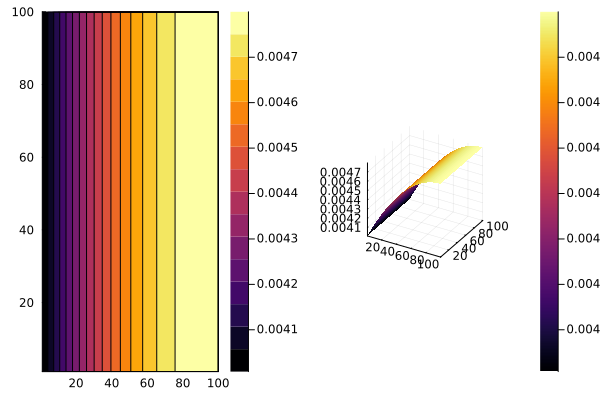

In [118]:
# grid = generate_grid(Quadrilateral, (100, 100));
nelem = 100 
nels  = (nelem, nelem) # number of elements in each spatial direction
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

ch = ConstraintHandler(dh);

# Boundary conditions part: Dirichlet BC for the velocity at the top lid 
left_patch = getfacetset(dh.grid, "left")
if (true)
    dbc1 = Dirichlet(:u, left_patch, (x,t) ->  10. )
else 
    dbc1 = setup_mean_constraint(dh, fvu)
end 
add!(ch, dbc1)

close!(ch);

K = allocate_matrix(dh,ch);
M = allocate_matrix(dh,ch);
f = zeros(ndofs(dh));

K, f = assemble_K!(K, f, cellvalues, dh);
apply!(K, f, ch)
u = K \ f;

VTKGridFile("diffusion", dh) do vtk
    write_solution(vtk, dh, u)
    Ferrite.write_constraints(vtk, ch)
end

area, myu2d = mypostprocess(u, dh, cvu, nels)
p1 = contour(myu2d', fill=true)
p2 = surface(myu2d', fill=true)
plot(p1,p2, layout=(1,2))